## Združevanje kategorij

Po pregledu najpogostejših besed v določenih clustrih, sva sestavila dodaten sesznam besed, ki sva jih izločila - besede so se nanašale predvsem na razne tehnične termine iz računalniškega jezika.

Glede na analizo besedišča v clustrih in primerjave razporeditvi mailov glede na clustre in oznake, sva ugotovila da bo najlažje vse kategorije, ki vsebujejo manj kot 100 mailov (tam je bila klasifikacijska točnost prej precej slaba), združiti s kategorijo "Drugo". Po tej združitvi sva ponovno pognala prej uporabljene modele, ki so zdaj pokazali opazen napredek. Pri določenih kategorijah še vedno prihaja do precejšnje količine napačnih pozitivov ali negativov. 

Za potrebe končne analize izčiščenega besedila v primerjavi z izhodiščnim, sva ponovno izvozila pogostost besed glede na končne (združene) kategorije.

In [1]:
import pandas as pd
import os
import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.corpus import stopwords
import re
import string

import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle

import logging
from numpy import random
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier

import seaborn as sns

In [2]:
df = pd.read_csv ("after_klasla.csv")
df['tokenized'] = df['tokenized'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))
df['tokenized'] = df['tokenized'].apply(lambda x: " ".join(x.split()))

In [3]:
df

,class,content,tokenized
0,Asistenca,"Obveščamo vas, da je od kreiranja primera CUDV...",kreiranje primer cudv črn koroški vprašanje pr...
1,Asistenca,"Obveščamo vas, da je od kreiranja primera DAVI...",kreiranje primer seč vprašanje prejet miniti m...
2,Asistenca,vv\n\nOd: arc@assist-austria.com <arc@assist-a...,poslan četrtek januar zadevati existing case akc
3,Asistenca,"Obveščamo vas, da je od kreiranja primera ALEŠ...",kreiranje primer ruter vprašanje prejet miniti...
4,Asistenca,"Obveščamo vas, da je od kreiranja primera SUMM...",kreiranje primer leasing vprašanje prejet mini...
...,...,...,...
35693,Življenje,"<html><head>_x000D_\n<meta http-equiv=""Content...",zanimati možnost dobiti izplačan privarčevan s...
35694,Življenje,"<html><head>_x000D_\n<meta http-equiv=""Content...",zanimati kdaj poteči zavarovalen pogodba infor...
35695,Življenje,Pozdravljeni\nProsim za podatek kdaj lahko dob...,podatek kdaj dobiti izplačan sredstvo nataša r...
35696,Življenje,"Pozdravljeni,\n\ndo 31.12. mi je moj prejšnji ...",prejšnji delodajalec vplačevati sklad dodaten ...


In [4]:
def remove_stopwords(df):

    
    dodatne = [
 'company','underline','cambria','filtered','msochpdefault','vlink','math','potnislog','informacija',
 'zavarovalnica','cesta','ftwitter','received','contain','immediately','received','reg','environment',
 'iso','contain','ulica','environment','stran','dg',"imeti","podatek","ime","priimek","...","prejeti",
 "sporočilo","čas", "primer","nov","iso","roman","times","math","vlink","filtered","msochpdefault",
 "msonormaltable","collapse","black", "underline", "naslovznak","bold", "msohyperlink","underline", 
 "visited","purple","barbara","lorger", "wrap","windows", "cambria","weight", "bold","blue","slika", 
 "attachment","break", "emailquot","plaintext", "converted", "explore", "ftags", "disclosure", "distribution", 
 "gebrüder", "weiss","commercial", "register","terms", "conditions", "general", "assetspartnerid","lifepartnerid",
 "healthpartnerid","min","impresum", "imeti", "poslati", "pošiljati", "prejeti", "ljubljana"]
    
    #REMOVE STOPWORDS 
    df['tokenized'] = df['tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in (dodatne)]))
    
    
    return df

In [5]:
df = remove_stopwords(df)

In [6]:
print(df['class'].value_counts())

Premoženje                         15432
Asistenca brez primera             10280
Življenje                           2937
Drajv                               2908
drugo                               1919
Zdravje                              966
PDPZ                                 516
Odjava B2B                           331
Asistenca                            277
Marketinške akcije                    53
GDPR                                  43
Banke                                 17
CORIS                                 12
Zavarovanja - zunanji partnerji        5
Help desk - interna javnost            2
Name: class, dtype: int64


In [7]:
df = df.replace({"drugo":"Drugo", "CORIS":"Drugo", "Marketinške akcije":"Drugo", "GDPR":"Drugo","Banke":"Drugo",
                 "Zavarovanja - zunanji partnerji":"Drugo","Help desk - interna javnost": "Drugo"})

In [8]:
print(df['class'].value_counts())

Premoženje                15432
Asistenca brez primera    10280
Življenje                  2937
Drajv                      2908
Drugo                      2051
Zdravje                     966
PDPZ                        516
Odjava B2B                  331
Asistenca                   277
Name: class, dtype: int64


In [9]:
df.groupby(["class"]).count()

,content,tokenized
class,,
Asistenca,277,277
Asistenca brez primera,10280,10280
Drajv,2908,2908
Drugo,2051,2051
Odjava B2B,331,331
PDPZ,516,516
Premoženje,15432,15432
Zdravje,966,966
Življenje,2937,2937


In [10]:
#NASTAVITEV PARAMETROV

#working dataframe --> pp_df (pre-processed dataframe)

my_tags= ['Asistenca',
             'Asistenca brez primera',
             'Drajv',
             'Drugo',
             'Odjava B2B',
             'PDPZ',
             'Premoženje',
             'Zdravje',
             'Življenje']

X = df["tokenized"]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [11]:
%%time

#NAIVE BAYES


from time import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7268483150836093
                        precision    recall  f1-score   support

             Asistenca       1.00      0.55      0.71        88
Asistenca brez primera       0.98      0.90      0.94      3438
                 Drajv       1.00      0.48      0.65       937
                 Drugo       0.50      0.01      0.01       686
            Odjava B2B       0.00      0.00      0.00       124
                  PDPZ       0.00      0.00      0.00       179
            Premoženje       0.61      0.99      0.76      4997
               Zdravje       0.00      0.00      0.00       331
             Življenje       0.86      0.01      0.01      1001

              accuracy                           0.73     11781
             macro avg       0.55      0.33      0.34     11781
          weighted avg       0.73      0.73      0.65     11781

CPU times: user 2.34 s, sys: 80.3 ms, total: 2.42 s
Wall time: 2.44 s


/Users/Intragalactic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Intragalactic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Intragalactic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [12]:
%%time
#LINEAR SUPPORT VECTOR


from sklearn.linear_model import SGDClassifier


sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=45, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7685255920550038
                        precision    recall  f1-score   support

             Asistenca       1.00      0.83      0.91        88
Asistenca brez primera       0.97      0.91      0.94      3438
                 Drajv       0.96      0.84      0.90       937
                 Drugo       0.00      0.00      0.00       686
            Odjava B2B       0.00      0.00      0.00       124
                  PDPZ       0.61      0.14      0.23       179
            Premoženje       0.66      0.98      0.79      4997
               Zdravje       0.65      0.05      0.10       331
             Življenje       0.74      0.14      0.24      1001

              accuracy                           0.77     11781
             macro avg       0.62      0.43      0.45     11781
          weighted avg       0.74      0.77      0.71     11781

CPU times: user 3.08 s, sys: 69.5 ms, total: 3.15 s
Wall time: 2.72 s


/Users/Intragalactic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Intragalactic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Intragalactic/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

accuracy 0.836261777438248
                        precision    recall  f1-score   support

             Asistenca       0.97      0.83      0.90        88
Asistenca brez primera       0.97      0.95      0.96      3438
                 Drajv       0.97      0.89      0.93       937
                 Drugo       0.55      0.32      0.41       686
            Odjava B2B       0.53      0.32      0.40       124
                  PDPZ       0.69      0.47      0.56       179
            Premoženje       0.79      0.91      0.84      4997
               Zdravje       0.67      0.50      0.57       331
             Življenje       0.71      0.62      0.66      1001

              accuracy                           0.84     11781
             macro avg       0.76      0.65      0.69     11781
          weighted avg       0.83      0.84      0.83     11781



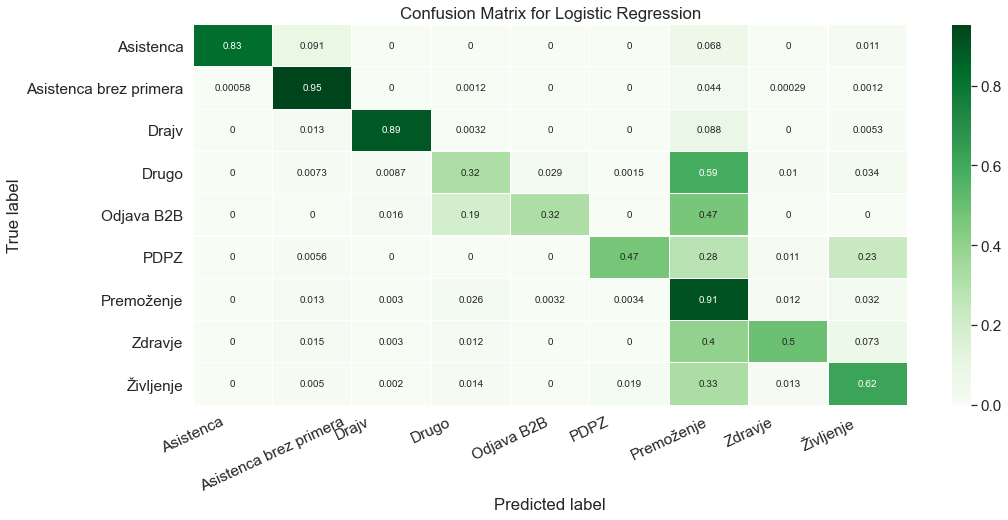

CPU times: user 1min 56s, sys: 3.63 s, total: 2min
Wall time: 1min 7s


In [13]:
%%time

#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=None, C=10, solver='lbfgs', max_iter=500,
                                          )),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = my_tags
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [14]:
def df_to_plots_table(vnos):
    
    
    df['tokenized'] = df['tokenized'].apply(lambda x: " ".join(x.split()))
    vnos = vnos.drop(columns=["content"])
    
    
    
    #SPODNJA VRSTICA SPREMENI DATAFRAME V SLOVAR, KJER SO RAZREDU KLJUČI, VREDNOSTI PA VSE BESEDE
    slovar = vnos.groupby('class').apply(lambda dfg: dfg.drop('class', axis=1).to_dict(orient='list')).to_dict()
    
    from nltk.probability import FreqDist
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib.font_manager import FontProperties

    
    %matplotlib inline
    
    my_tags= ['Asistenca',
             'Asistenca brez primera',
             'Drajv',
             'Drugo',
             'Odjava B2B',
             'PDPZ',
             'Premoženje',
             'Zdravje',
             'Življenje']
    
    for oznaka in my_tags:
        print(oznaka)
        seznam = (slovar[oznaka][vnos.columns[1]])
        besedilo = " ".join(seznam)
        besedilo = besedilo.split(" ")
        
        fdist = FreqDist()
        for beseda in besedilo:
            fdist[beseda]+=1
        
        
        fig = plt.figure(figsize=(22, 10))
        plt.title(oznaka)
        slika = fdist.plot(60)
        fdist_top60 = fdist.most_common(20)
        
        
        N = 8
        
        figa, ax1 = plt.subplots(figsize=(6, 2 + N / 2.5))
        title = oznaka
        ax1.set_title(f'{title}', weight='bold', size=14, color='k')
        
        table = plt.table(cellText = fdist_top60, 
                          colLabels = ('Beseda', 'Pojavnost'),
                          loc='center',
                          cellLoc='center')
        
        for (row, col), cell in table.get_celld().items():
            if (row == 0):
                cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        
        table.set_fontsize(8)
        ax1.axis('off')
        
        plt.axis('off')
        plt.grid('off')
          
        #prepare for saving:
        # draw canvas once
        plt.gcf().canvas.draw()
        # get bounding box of table
        points = table.get_window_extent(plt.gcf()._cachedRenderer).get_points()
        # add 10 pixel spacing
        points[0,:] -= 10; points[1,:] += 10
        # get new bounding box in inches
        nbbox = matplotlib.transforms.Bbox.from_extents(points/plt.gcf().dpi)
             
        # save and clip by new bounding box
        plt.savefig(oznaka+"_table_0530_final.jpg", dpi=200, bbox_inches='tight')
        
        print(slika)
        print(fdist_top60)
        fig.savefig(oznaka + '_0530_final.jpg',dpi=300)

Asistenca


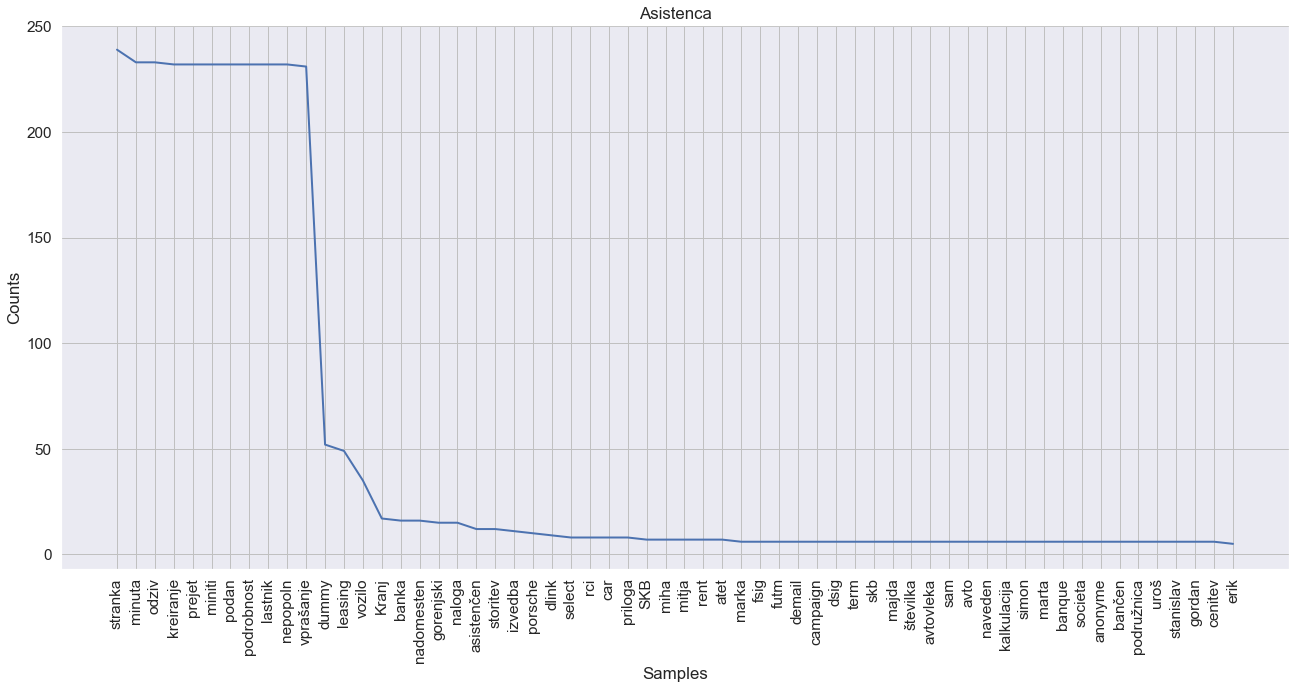

AxesSubplot(0.125,0.125;0.775x0.755)
[('stranka', 239), ('minuta', 233), ('odziv', 233), ('kreiranje', 232), ('prejet', 232), ('miniti', 232), ('podan', 232), ('podrobnost', 232), ('lastnik', 232), ('nepopoln', 232), ('vprašanje', 231), ('dummy', 52), ('leasing', 49), ('vozilo', 35), ('Kranj', 17), ('banka', 16), ('nadomesten', 16), ('gorenjski', 15), ('naloga', 15), ('asistenčen', 12)]
Asistenca brez primera


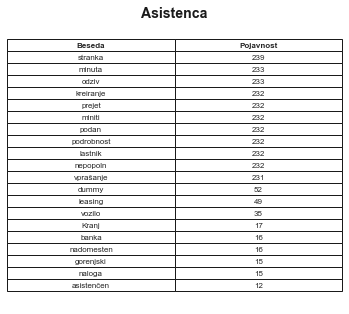

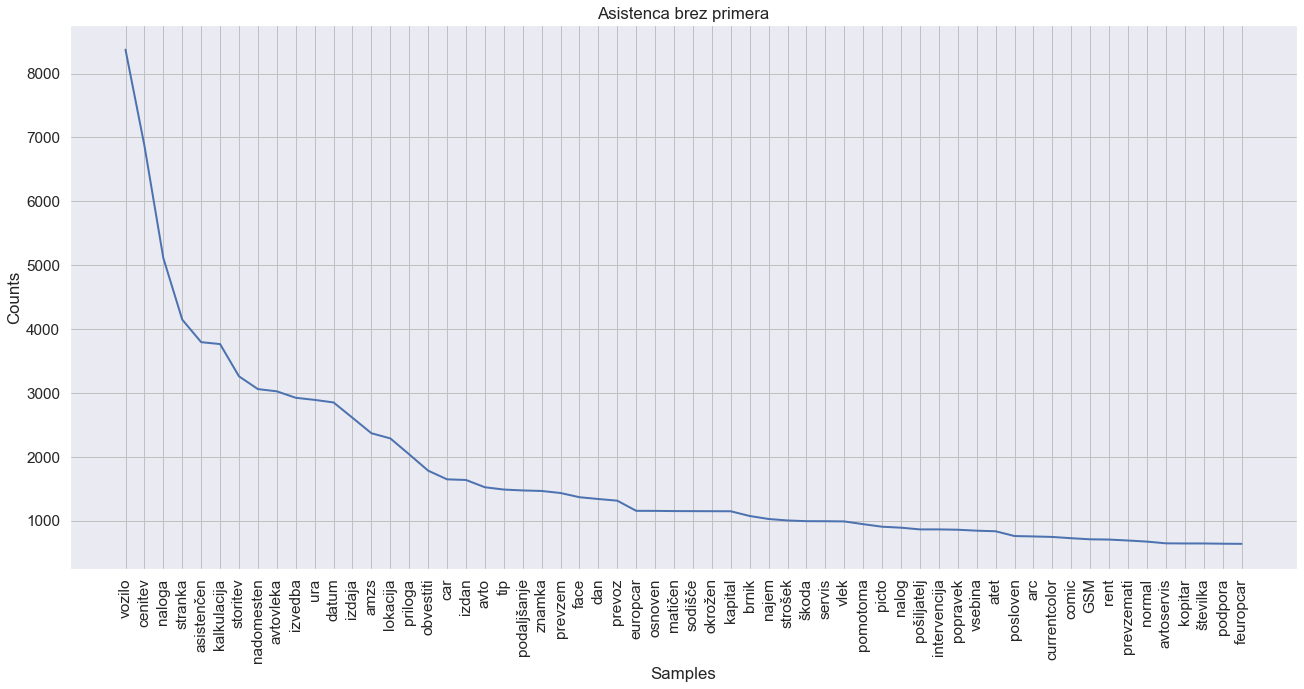

AxesSubplot(0.125,0.125;0.775x0.755)
[('vozilo', 8374), ('cenitev', 6872), ('naloga', 5111), ('stranka', 4147), ('asistenčen', 3794), ('kalkulacija', 3764), ('storitev', 3259), ('nadomesten', 3059), ('avtovleka', 3024), ('izvedba', 2923), ('ura', 2890), ('datum', 2850), ('izdaja', 2610), ('amzs', 2368), ('lokacija', 2287), ('priloga', 2037), ('obvestiti', 1782), ('car', 1646), ('izdan', 1636), ('avto', 1522)]
Drajv


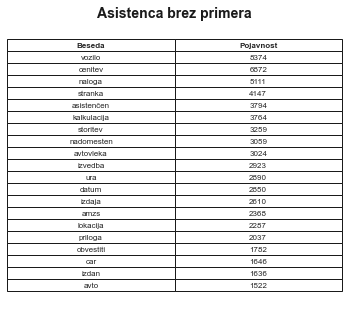

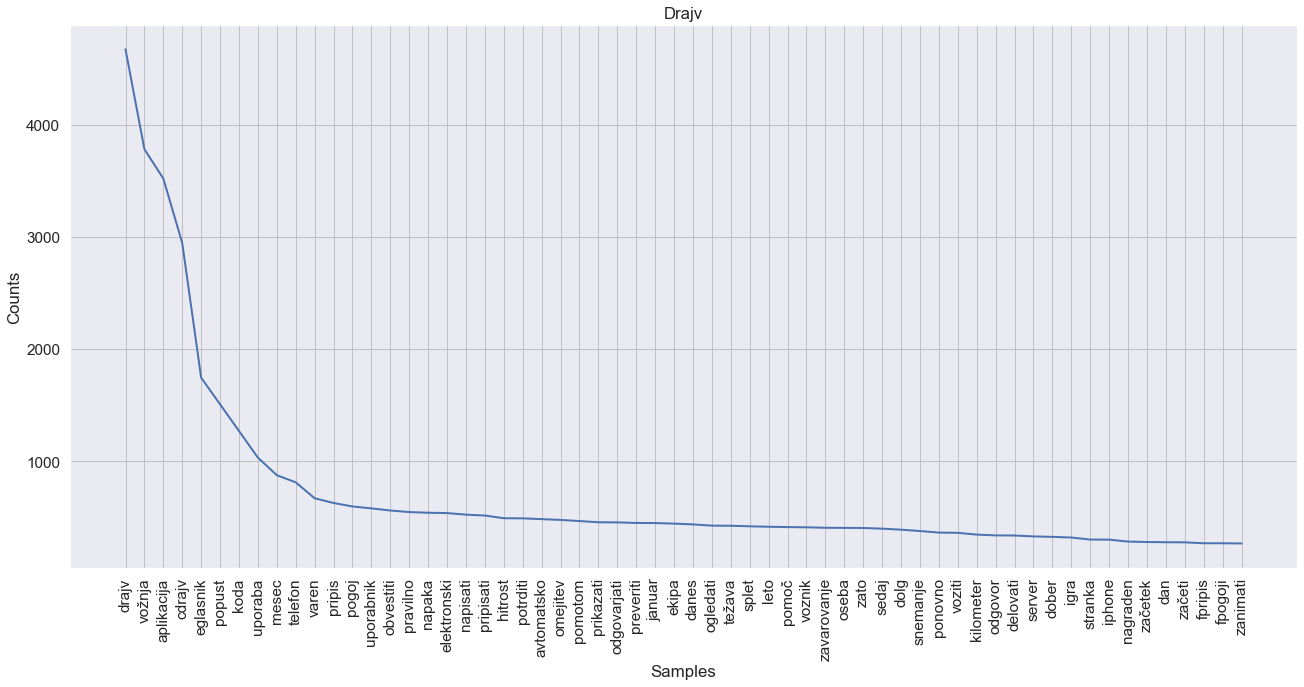

AxesSubplot(0.125,0.125;0.775x0.755)
[('drajv', 4676), ('vožnja', 3785), ('aplikacija', 3523), ('cdrajv', 2948), ('eglasnik', 1747), ('popust', 1510), ('koda', 1272), ('uporaba', 1034), ('mesec', 878), ('telefon', 814), ('varen', 672), ('pripis', 630), ('pogoj', 599), ('uporabnik', 582), ('obvestiti', 563), ('pravilno', 549), ('napaka', 543), ('elektronski', 540), ('napisati', 526), ('pripisati', 518)]
Drugo


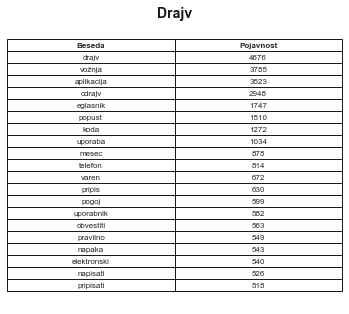

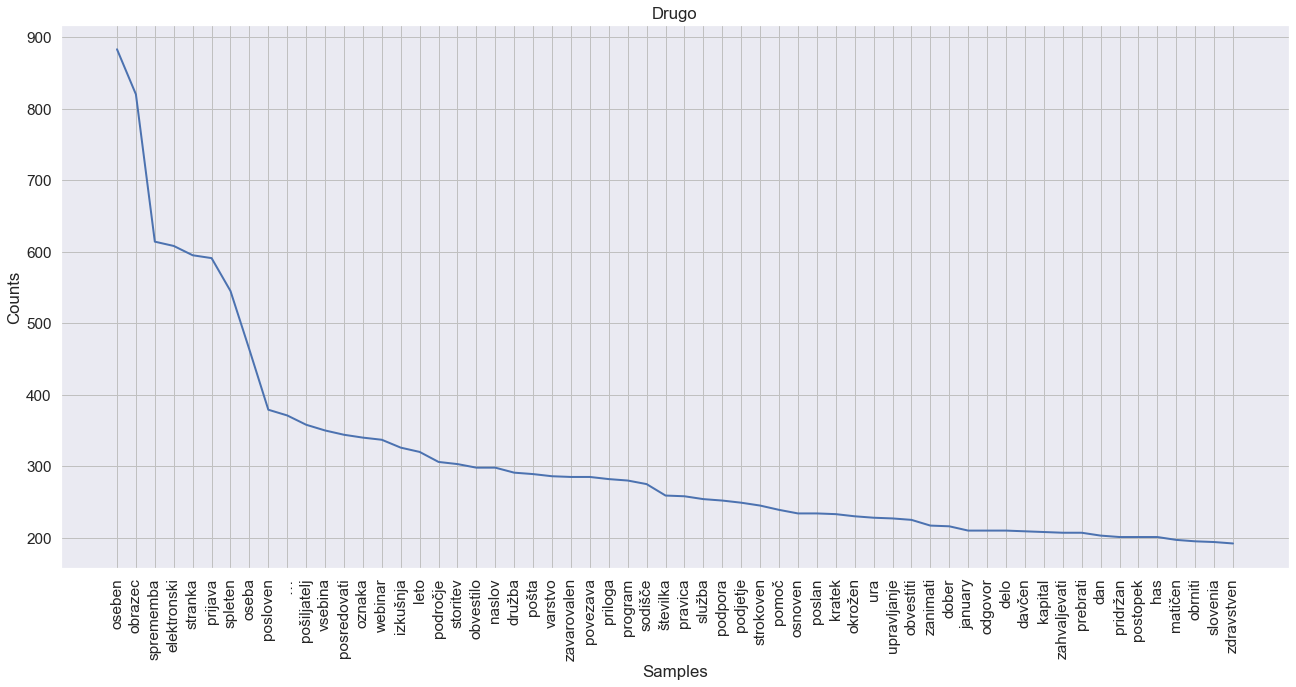

AxesSubplot(0.125,0.125;0.775x0.755)
[('oseben', 883), ('obrazec', 820), ('sprememba', 614), ('elektronski', 608), ('stranka', 595), ('prijava', 591), ('spleten', 545), ('oseba', 463), ('posloven', 379), ('…', 371), ('pošiljatelj', 358), ('vsebina', 350), ('posredovati', 344), ('oznaka', 340), ('webinar', 337), ('izkušnja', 326), ('leto', 320), ('področje', 306), ('storitev', 303), ('obvestilo', 298)]
Odjava B2B


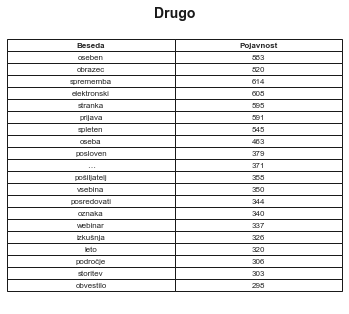

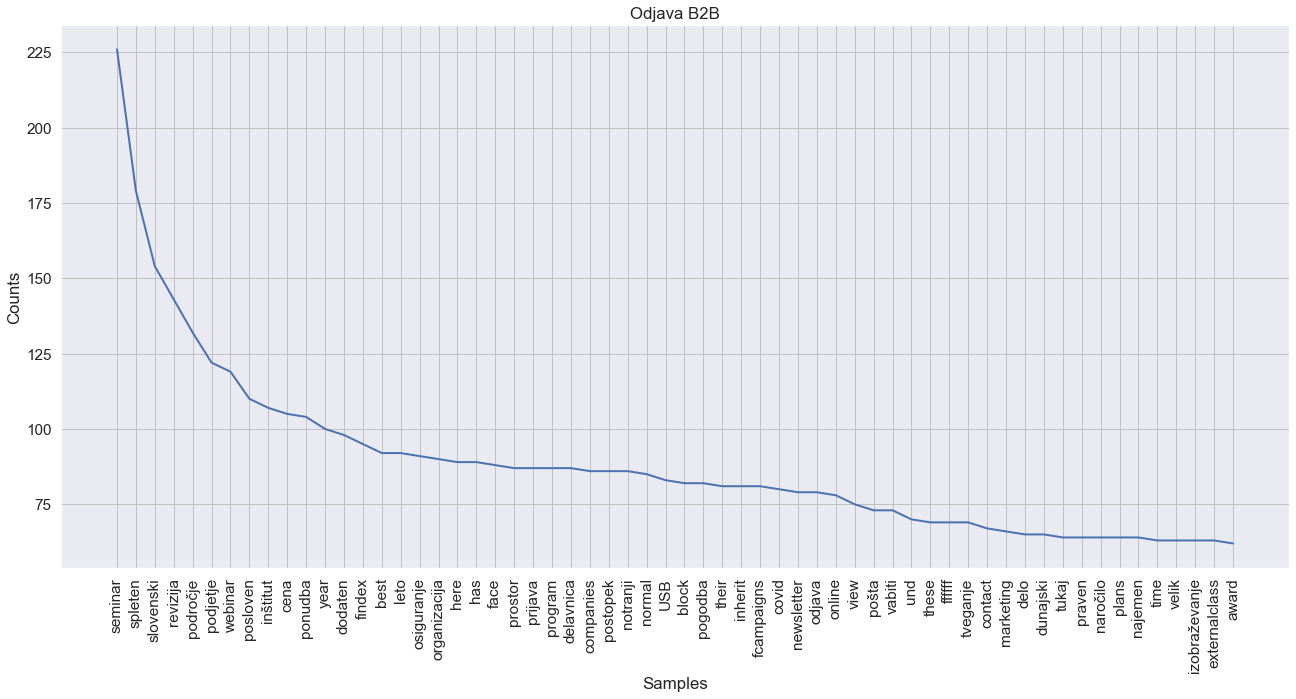

AxesSubplot(0.125,0.125;0.775x0.755)
[('seminar', 226), ('spleten', 179), ('slovenski', 154), ('revizija', 143), ('področje', 132), ('podjetje', 122), ('webinar', 119), ('posloven', 110), ('inštitut', 107), ('cena', 105), ('ponudba', 104), ('year', 100), ('dodaten', 98), ('findex', 95), ('best', 92), ('leto', 92), ('osiguranje', 91), ('organizacija', 90), ('here', 89), ('has', 89)]
PDPZ


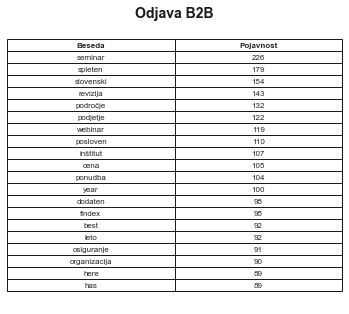

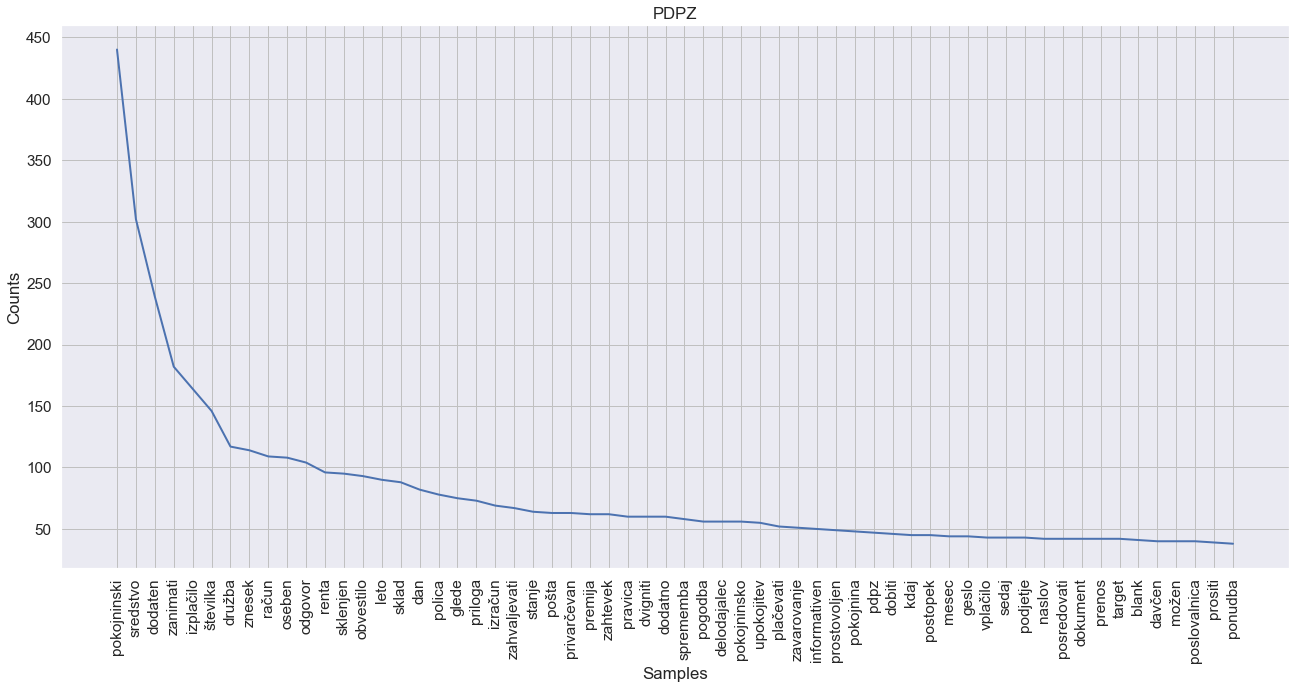

AxesSubplot(0.125,0.125;0.775x0.755)
[('pokojninski', 440), ('sredstvo', 302), ('dodaten', 239), ('zanimati', 182), ('izplačilo', 164), ('številka', 146), ('družba', 117), ('znesek', 114), ('račun', 109), ('oseben', 108), ('odgovor', 104), ('renta', 96), ('sklenjen', 95), ('obvestilo', 93), ('leto', 90), ('sklad', 88), ('dan', 82), ('polica', 78), ('glede', 75), ('priloga', 73)]
Premoženje


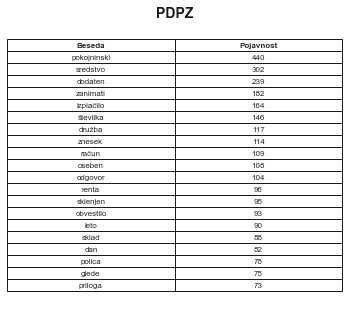

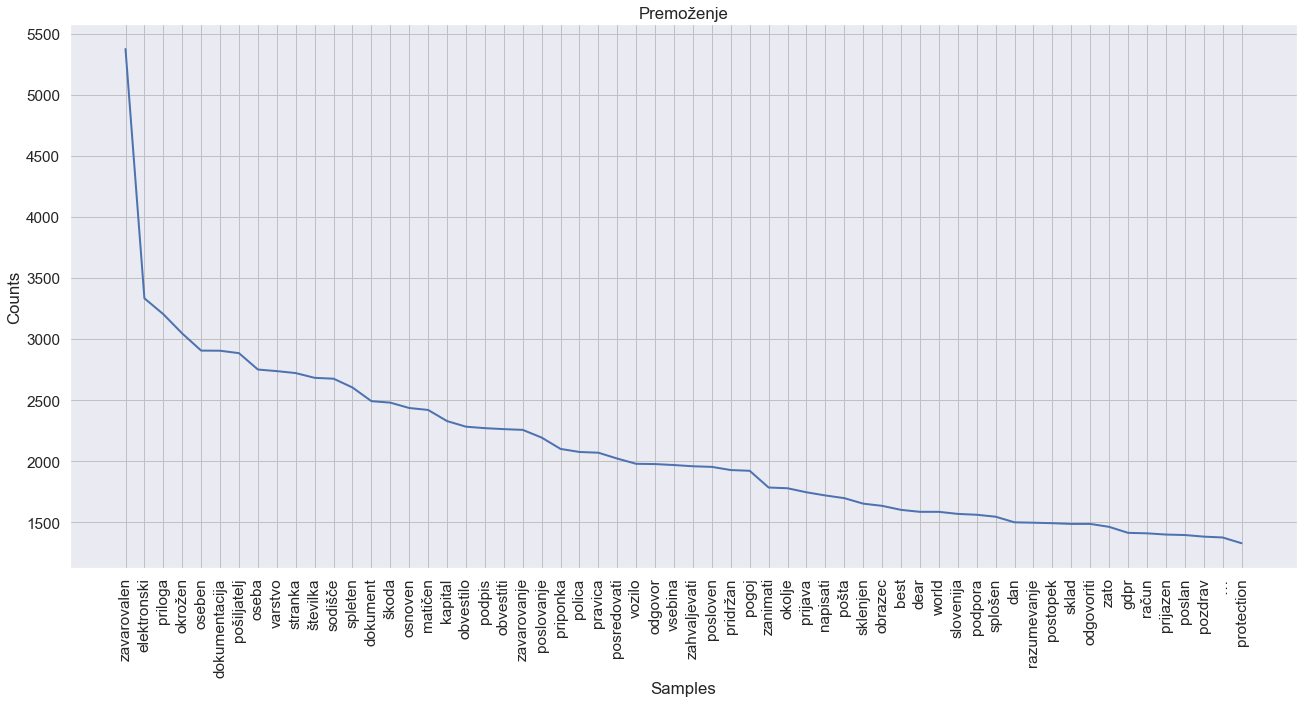

AxesSubplot(0.125,0.125;0.775x0.755)
[('zavarovalen', 5375), ('elektronski', 3334), ('priloga', 3204), ('okrožen', 3046), ('oseben', 2906), ('dokumentacija', 2905), ('pošiljatelj', 2885), ('oseba', 2751), ('varstvo', 2738), ('stranka', 2722), ('številka', 2683), ('sodišče', 2676), ('spleten', 2604), ('dokument', 2492), ('škoda', 2480), ('osnoven', 2436), ('matičen', 2420), ('kapital', 2329), ('obvestilo', 2283), ('podpis', 2271)]
Zdravje


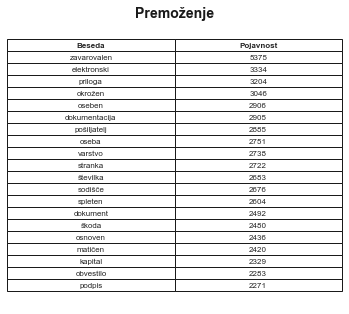

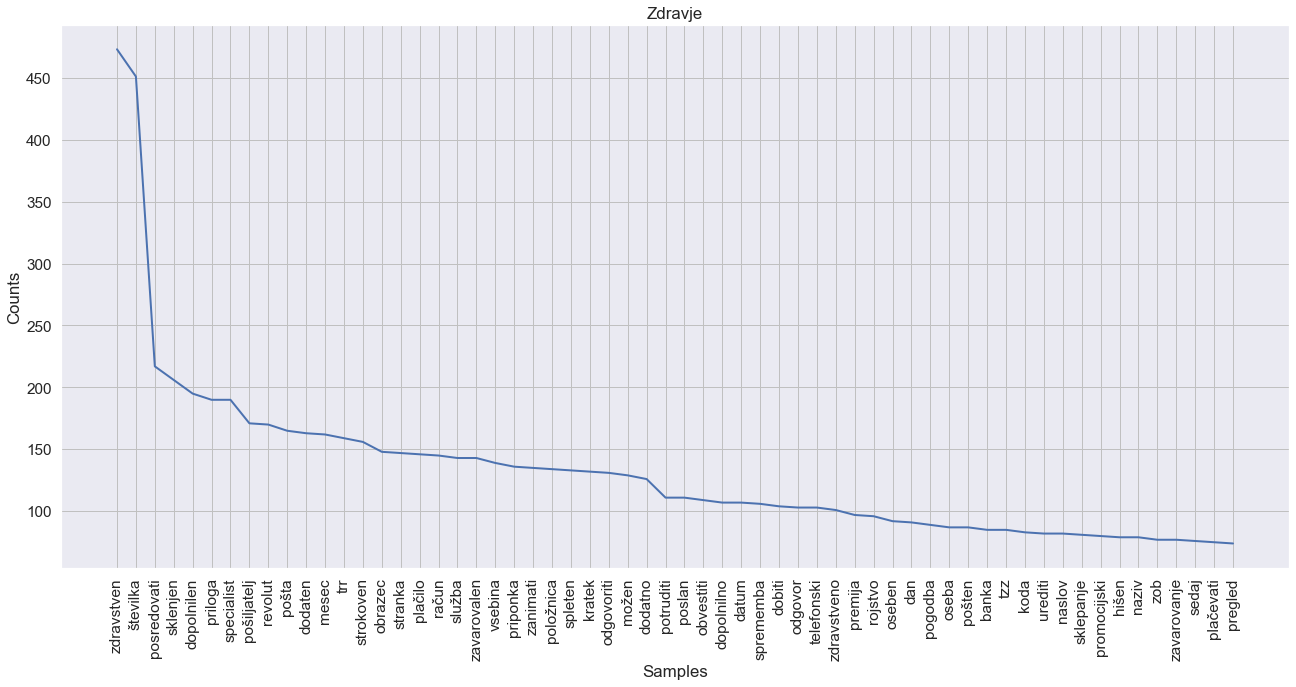

AxesSubplot(0.125,0.125;0.775x0.755)
[('zdravstven', 473), ('številka', 451), ('posredovati', 217), ('sklenjen', 206), ('dopolnilen', 195), ('priloga', 190), ('specialist', 190), ('pošiljatelj', 171), ('revolut', 170), ('pošta', 165), ('dodaten', 163), ('mesec', 162), ('trr', 159), ('strokoven', 156), ('obrazec', 148), ('stranka', 147), ('plačilo', 146), ('račun', 145), ('služba', 143), ('zavarovalen', 143)]
Življenje


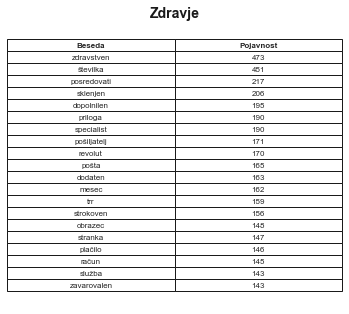

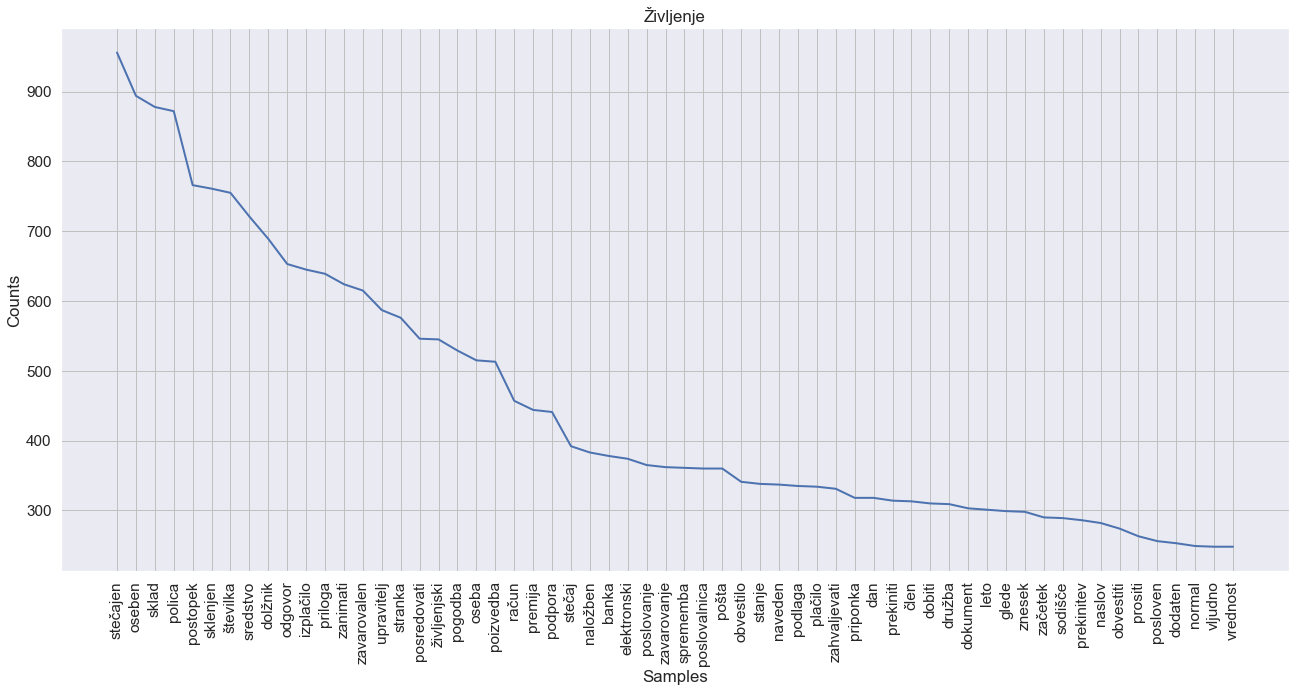

AxesSubplot(0.125,0.125;0.775x0.755)
[('stečajen', 956), ('oseben', 894), ('sklad', 878), ('polica', 872), ('postopek', 766), ('sklenjen', 761), ('številka', 755), ('sredstvo', 721), ('dolžnik', 689), ('odgovor', 653), ('izplačilo', 645), ('priloga', 639), ('zanimati', 624), ('zavarovalen', 615), ('upravitelj', 587), ('stranka', 576), ('posredovati', 546), ('življenjski', 545), ('pogodba', 529), ('oseba', 515)]


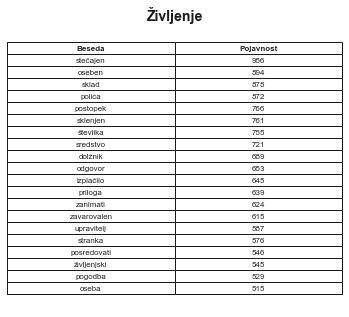

In [15]:
df_to_plots_table(df)